# Open Exploration

The open exploration is performed prior to the MORDM. This notebook looks at the base case first, where no policies are implemented. This means that all policy levers are set to zero. This base case is evaluated under 10,000 scenarios using Latin Hypercube Sampling. 

From these scenarios the worst-case scenario is chosen in terms of deaths.

Subsequently, an understanding of the political arena and the model is performed through looking at both problem formulations 5 and 8. Problem formulation 5 shows a disaggregated viewpoint, through which we can find which dike rings are most affected, and what the influence of time-steps are. These are depicted using histograms.

Problem formulation 8 shows the holistic point of view, and is used to show the impact of four different chosen policies: No policy action, dike heightening in Gelderland, dike heightening everywhere, and all policy actions. This is to gain a deeper understanding of what the impact of policies are, and allows us to gain more understanding prior to performing the multi-scenario MORDM.

## Imports

In [1]:
# Standard Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import networkx as nx
import scipy as sp

# Workbench Imports
from ema_workbench import (Model, Policy, MultiprocessingEvaluator, ScalarOutcome, RealParameter, IntegerParameter, CategoricalParameter, optimize, Scenario, Constant, ema_logging,perform_experiments, SequentialEvaluator)
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from ema_workbench.util import ema_logging, save_results, load_results
from ema_workbench.em_framework.samplers import sample_levers, sample_uncertainties
#from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS, SequentialEvaluator, BaseEvaluator


ema_logging.log_to_stderr(ema_logging.INFO)


<Logger EMA (DEBUG)>

## Model Specification

In [2]:
# Model Imports
from dike_model_function import DikeNetwork
from problem_formulation import get_model_for_problem_formulation

dike_model, time_step = get_model_for_problem_formulation(6)

We specify a reference policy, where no measures are implemented to assess the impacts of such inaction. 

In [3]:
policy_noaction = Policy("NoAction",  
                    **{'0_RfR 0': 0, '0_RfR 1' : 0, '0_RfR 2' : 0,
                    '1_RfR 0': 0, '1_RfR 1' : 0, '1_RfR 2' : 0,
                    '2_RfR 0': 0, '2_RfR 1' : 0, '2_RfR 2' : 0,
                    '3_RfR 0': 0, '3_RfR 1' : 0, '3_RfR 2' : 0,
                    '4_RfR 0': 0, '4_RfR 1' : 0, '4_RfR 2' : 0,
                    'A.1_DikeIncrease 0' : 0, 'A.1_DikeIncrease 1' : 0, 'A.1_DikeIncrease 2' : 0,
                    'A.2_DikeIncrease 0' : 0, 'A.2_DikeIncrease 1' : 0, 'A.2_DikeIncrease 2' : 0,
                    'A.3_DikeIncrease 0' : 0, 'A.3_DikeIncrease 1' : 0, 'A.3_DikeIncrease 2' : 0,
                    'A.4_DikeIncrease 0' : 0, 'A.4_DikeIncrease 1' : 0, 'A.4_DikeIncrease 2' : 0,
                    'A.5_DikeIncrease 0' : 0, 'A.5_DikeIncrease 1' : 0, 'A.5_DikeIncrease 2' : 0,
                    'EWS_DaysToThreat':  0   })



The reference case to be used for the problem formulations of Gelderland, Overijssel and the Holistic view will all be from the same run. This will ensure that they are optimising based on the same reference scenario and theoretically the same base.

In [ ]:
n_scenarios = 10000

ema_logging.log_to_stderr(ema_logging.INFO)
 
with MultiprocessingEvaluator(dike_model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=n_scenarios, policies=policy_noaction)

In [ ]:
#Save the results
save_results([experiments, outcomes], "../results/10000Scenarios_NoAction_PF6.tar.gz")

In [ ]:
#Load results
worst_case = load_results("../results/10000Scenarios_NoAction_PF6.tar.gz")

[MainProcess/INFO] results loaded succesfully from C:\Users\Timme\Desktop\EPA\model-based-decision-making\results\10000Scenarios_NoAction_PF1.tar.gz


# 2. Data Visualisaiton on the Problem Arena

To gain a thorough understanding of the policy arena, and understanding the model, it is best to analyse the data in the most disaggregated manner. This is done through looking at problem formulation 5.

In [4]:
n_scenarios = 1000

ema_logging.log_to_stderr(ema_logging.INFO)

# Model Imports
from dike_model_function import DikeNetwork
from problem_formulation import get_model_for_problem_formulation

dike_model, time_step = get_model_for_problem_formulation(5)
 
with MultiprocessingEvaluator(dike_model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=n_scenarios, policies=policy_noaction)

In [ ]:
save_results([experiments,outcomes],'../results/OpenExpl_1000_NoPolicy_PF5')

[MainProcess/INFO] results saved successfully to C:\Users\Samuel\Desktop\Studies\EPA\EPA1361 - Model Based Decision Making\model-based-decision-making\results\OpenExpl_1000_NoPolicy_PF5


## 2.1 Histogram Plots

Through running experiments on Problem Formulation 5 we can look at the distribution of outcomes over both the location and during different time steps. The model has been specified to use three time steps. The reference case used is still where no policy action is taken. This results in no cost by any of the dikes/locations on both dike heightening and RfR measures. 

2.1.1 Expected Number of Deaths

In [ ]:
def histogram_maker(results, outcome, n=3):
    '''
    Function used to create multiple histograms for for numerous locations and across the multiple time steps. 
    Parameters
    ----------
    results : dataframe 
    outcome : str
    n : int (time steps)
    '''

    locations = ["A.1", "A.2", "A.3", "A.4", "A.5"]
    colors = ['tab:red', 'tab:orange', 'tab:green', 'tab:blue', 'tab:olive']

    print("Plot " + str(outcome) + "(Histogram)")
    for step in range(0, n):
        print("This is timestep " + str(step))
        fig, axes = plt.subplots(1, 5, figsize=(10, 3))

        for i, (ax, place) in enumerate(zip(axes.flatten(), locations)):
            #ax.hist(results[str(place) + "_Expected Annual Damage " + str(step)], color=colors[i])
            ax.hist(results[str(place) + "_" + str(outcome) +
                            " " + str(step)], color=colors[i])
            ax.set_xlim(left=0)
            ax.set_title(place)

        plt.tight_layout()
        plt.show()
        
# https://stackoverflow.com/a/56253636

In [ ]:
results_df = pd.concat([experiments, pd.DataFrame(outcomes)],axis = 1)

Plot Expected Number of Deaths(Histogram)
This is timestep 0


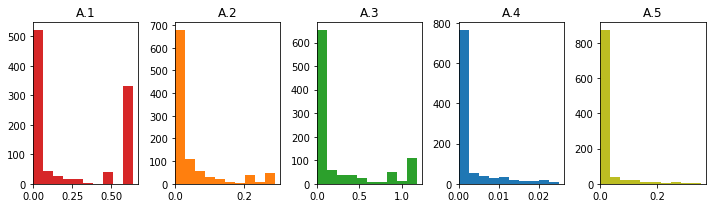

This is timestep 1


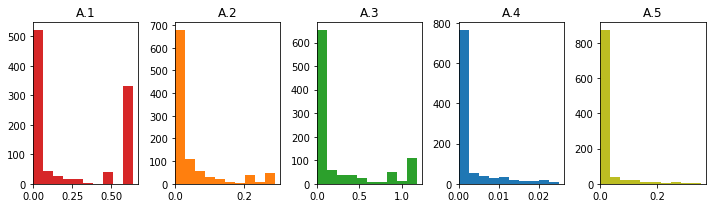

This is timestep 2


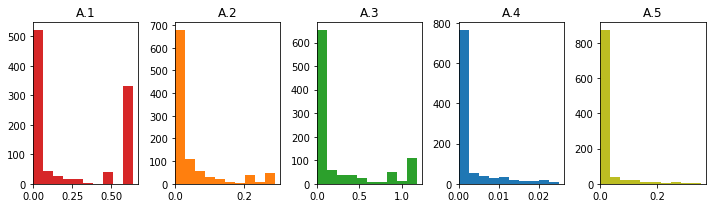

In [ ]:
histogram_maker(results_df,"Expected Number of Deaths")

Plot Expected Annual Damage(Histogram)
This is timestep 0


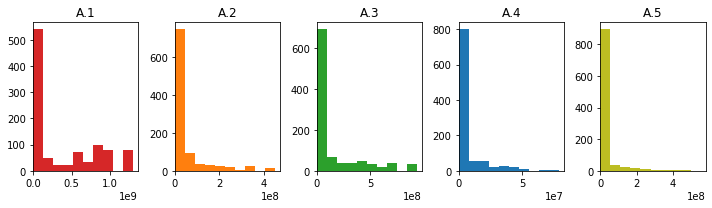

This is timestep 1


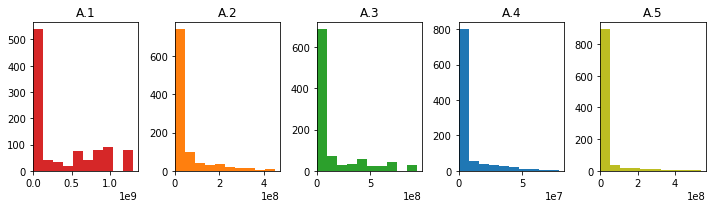

This is timestep 2


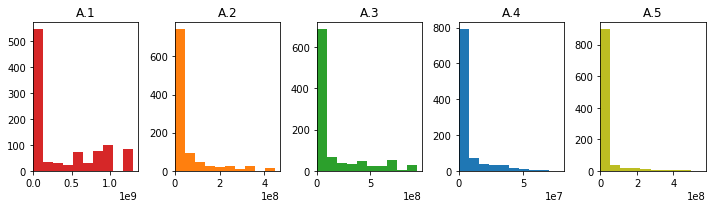

In [ ]:
histogram_maker(results_df,"Expected Annual Damage")

# 3. Open Policy exploration

In [ ]:
# Exploration of alternative policy ideas:

policy_g_dikes = Policy("Gelderland_Dikes",  
                    **{'0_RfR 0': 0, '0_RfR 1' : 0, '0_RfR 2' : 0,
                    '1_RfR 0': 0, '1_RfR 1' : 0, '1_RfR 2' : 0,
                    '2_RfR 0': 0, '2_RfR 1' : 0, '2_RfR 2' : 0,
                    '3_RfR 0': 0, '3_RfR 1' : 0, '3_RfR 2' : 0,
                    '4_RfR 0': 0, '4_RfR 1' : 0, '4_RfR 2' : 0,
                    'A.1_DikeIncrease 0' : 10, 'A.1_DikeIncrease 1' : 0, 'A.1_DikeIncrease 2' : 0,
                    'A.2_DikeIncrease 0' : 10, 'A.2_DikeIncrease 1' : 0, 'A.2_DikeIncrease 2' : 0,
                    'A.3_DikeIncrease 0' : 10, 'A.3_DikeIncrease 1' : 0, 'A.3_DikeIncrease 2' : 0,
                    'A.4_DikeIncrease 0' : 0, 'A.4_DikeIncrease 1' : 0, 'A.4_DikeIncrease 2' : 0,
                    'A.5_DikeIncrease 0' : 0, 'A.5_DikeIncrease 1' : 0, 'A.5_DikeIncrease 2' : 0,
                    'EWS_DaysToThreat':  0   })

policy_all_dikes = Policy("All_dikes",  
                    **{'0_RfR 0': 0, '0_RfR 1' : 0, '0_RfR 2' : 0,
                    '1_RfR 0': 0, '1_RfR 1' : 0, '1_RfR 2' : 0,
                    '2_RfR 0': 0, '2_RfR 1' : 0, '2_RfR 2' : 0,
                    '3_RfR 0': 0, '3_RfR 1' : 0, '3_RfR 2' : 0,
                    '4_RfR 0': 0, '4_RfR 1' : 0, '4_RfR 2' : 0,
                    'A.1_DikeIncrease 0' : 10, 'A.1_DikeIncrease 1' : 0, 'A.1_DikeIncrease 2' : 0,
                    'A.2_DikeIncrease 0' : 10, 'A.2_DikeIncrease 1' : 0, 'A.2_DikeIncrease 2' : 0,
                    'A.3_DikeIncrease 0' : 10, 'A.3_DikeIncrease 1' : 0, 'A.3_DikeIncrease 2' : 0,
                    'A.4_DikeIncrease 0' : 10, 'A.4_DikeIncrease 1' : 0, 'A.4_DikeIncrease 2' : 0,
                    'A.5_DikeIncrease 0' : 10, 'A.5_DikeIncrease 1' : 0, 'A.5_DikeIncrease 2' : 0,
                    'EWS_DaysToThreat':  0   })

policy_everything = Policy("Everything",  
                    **{'0_RfR 0': 1, '0_RfR 1' : 0, '0_RfR 2' : 0,
                    '1_RfR 0': 1, '1_RfR 1' : 0, '1_RfR 2' : 0,
                    '2_RfR 0': 1, '2_RfR 1' : 0, '2_RfR 2' : 0,
                    '3_RfR 0': 1, '3_RfR 1' : 0, '3_RfR 2' : 0,
                    '4_RfR 0': 1, '4_RfR 1' : 0, '4_RfR 2' : 0,
                    'A.1_DikeIncrease 0' : 10, 'A.1_DikeIncrease 1' : 0, 'A.1_DikeIncrease 2' : 0,
                    'A.2_DikeIncrease 0' : 10, 'A.2_DikeIncrease 1' : 0, 'A.2_DikeIncrease 2' : 0,
                    'A.3_DikeIncrease 0' : 10, 'A.3_DikeIncrease 1' : 0, 'A.3_DikeIncrease 2' : 0,
                    'A.4_DikeIncrease 0' : 10, 'A.4_DikeIncrease 1' : 0, 'A.4_DikeIncrease 2' : 0,
                    'A.5_DikeIncrease 0' : 10, 'A.5_DikeIncrease 1' : 0, 'A.5_DikeIncrease 2' : 0,
                    'EWS_DaysToThreat':  4   })

n_policies = 4

In [ ]:
ema_logging.log_to_stderr(ema_logging.INFO)
 
with MultiprocessingEvaluator(dike_model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=50, policies=policy_noaction)

In [ ]:
n_scenarios = 5000

ema_logging.log_to_stderr(ema_logging.INFO)

# Model Imports
from dike_model_function import DikeNetwork
from problem_formulation import get_model_for_problem_formulation

dike_model, time_step = get_model_for_problem_formulation(8)
 
with MultiprocessingEvaluator(dike_model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=n_scenarios, policies=[policy_noaction,policy_g_dikes,policy_all_dikes,policy_everything])

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 5000 scenarios * 4 policies * 1 model(s) = 20000 experiments
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] 12000 cases completed
[MainProcess/INFO] 14000 cases completed
[MainProcess/INFO] 16000 cases completed
[MainProcess/INFO] 18000 cases completed
[MainProcess/INFO] 20000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [ ]:
save_results([experiments,outcomes],'../results/OpenExp_5000Scenarios_FourPolicies_PF8')

[MainProcess/INFO] results saved successfully to C:\Users\Timme\Desktop\EPA\model-based-decision-making\results\OpenExp_5000Scenarios_FourPolicies_PF8


In [ ]:
experiments, outcomes = load_results('../results/OpenExp_5000Scenarios_FourPolicies_PF8')

[MainProcess/INFO] results loaded succesfully from C:\Users\Samuel\Desktop\Studies\EPA\EPA1361 - Model Based Decision Making\model-based-decision-making\results\OpenExp_5000Scenarios_FourPolicies_PF8


# 4. Statistical analysis of results

In [ ]:
n_scenarios = len(experiments)/n_policies

In [ ]:
# Outcomes, all policies
pd.DataFrame(outcomes).describe()

,Gelderland Expected Annual Damage,Overijssel Expected Annual Damage,Expected Number of Deaths,Gelderland Dike Cost,Overijssel Dike Cost,Room for River Investment Costs,Evacuation Costs
count,2.000000e+04,2.000000e+04,20000.000000,2.000000e+04,2.000000e+04,2.000000e+04,20000.000000
mean,4.167802e+08,7.718699e+07,0.464930,9.466399e+08,1.454416e+08,1.776000e+08,6.823491
std,9.667891e+08,1.907833e+08,0.937954,5.481381e+08,1.454452e+08,3.076199e+08,224.599725
min,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,0.000000e+00,0.000000e+00,0.000000,8.956791e+08,0.000000e+00,0.000000e+00,0.000000
50%,0.000000e+00,0.000000e+00,0.009339,1.245200e+09,1.454416e+08,0.000000e+00,0.000000
75%,4.343737e+07,6.364946e+07,0.356690,1.296160e+09,2.908831e+08,1.776000e+08,0.000000
max,6.656833e+09,1.624072e+09,5.733598,1.296160e+09,2.908831e+08,7.104000e+08,24733.901940


In [ ]:
# Do NOTHING Policy
pd.DataFrame(outcomes).iloc[:int(n_scenarios),:].describe()

,Gelderland Expected Annual Damage,Overijssel Expected Annual Damage,Expected Number of Deaths,Gelderland Dike Cost,Overijssel Dike Cost,Room for River Investment Costs,Evacuation Costs
count,5.000000e+03,5.000000e+03,5000.000000,5000.0,5000.0,5000.0,5000.0
mean,1.664993e+09,8.156381e+07,1.669594,0.0,0.0,0.0,0.0
std,1.288787e+09,1.959178e+08,1.225916,0.0,0.0,0.0,0.0
min,8.158376e+06,0.000000e+00,0.029400,0.0,0.0,0.0,0.0
25%,4.088868e+08,0.000000e+00,0.598956,0.0,0.0,0.0,0.0
50%,1.551638e+09,4.281571e+05,1.831360,0.0,0.0,0.0,0.0
75%,2.713616e+09,6.554702e+07,2.161018,0.0,0.0,0.0,0.0
max,6.656833e+09,1.512980e+09,5.733598,0.0,0.0,0.0,0.0


In [ ]:
# Do EVERYTHING Policy
pd.DataFrame(outcomes).iloc[int(n_scenarios*(n_policies-1)):int(n_scenarios*n_policies),:].describe()

,Gelderland Expected Annual Damage,Overijssel Expected Annual Damage,Expected Number of Deaths,Gelderland Dike Cost,Overijssel Dike Cost,Room for River Investment Costs,Evacuation Costs
count,5.000000e+03,5.000000e+03,5000.000000,5.000000e+03,5000.0,5000.0,5000.000000
mean,1.851709e+05,1.932789e+05,0.000054,1.296160e+09,290883138.0,710400000.0,27.293964
std,3.441980e+06,4.308503e+06,0.000760,0.000000e+00,0.0,0.0,448.610730
min,0.000000e+00,0.000000e+00,0.000000,1.296160e+09,290883138.0,710400000.0,0.000000
25%,0.000000e+00,0.000000e+00,0.000000,1.296160e+09,290883138.0,710400000.0,0.000000
50%,0.000000e+00,0.000000e+00,0.000000,1.296160e+09,290883138.0,710400000.0,0.000000
75%,0.000000e+00,0.000000e+00,0.000000,1.296160e+09,290883138.0,710400000.0,0.000000
max,1.893037e+08,2.705528e+08,0.034108,1.296160e+09,290883138.0,710400000.0,24733.901940


# 5. Visual analysis of results

In [ ]:
#experiments, outcomes = results
n_policies = 4
n_scenarios = len(experiments)/n_policies

policies = np.empty([len(experiments),1])
k = 0
l = n_scenarios
for i in range(len(experiments)):
    policies[i] = k
    if (i == l - 1):
        k = k + 1
        l = l + n_scenarios
policies = policies.astype(int)

data = pd.DataFrame.from_dict(outcomes)
data['policy']=policies

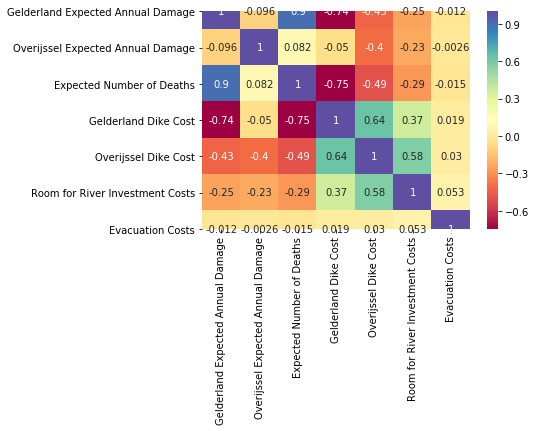

In [ ]:
sns.heatmap(pd.DataFrame(outcomes).corr(), annot=True, cmap = "Spectral")

Pairgrid

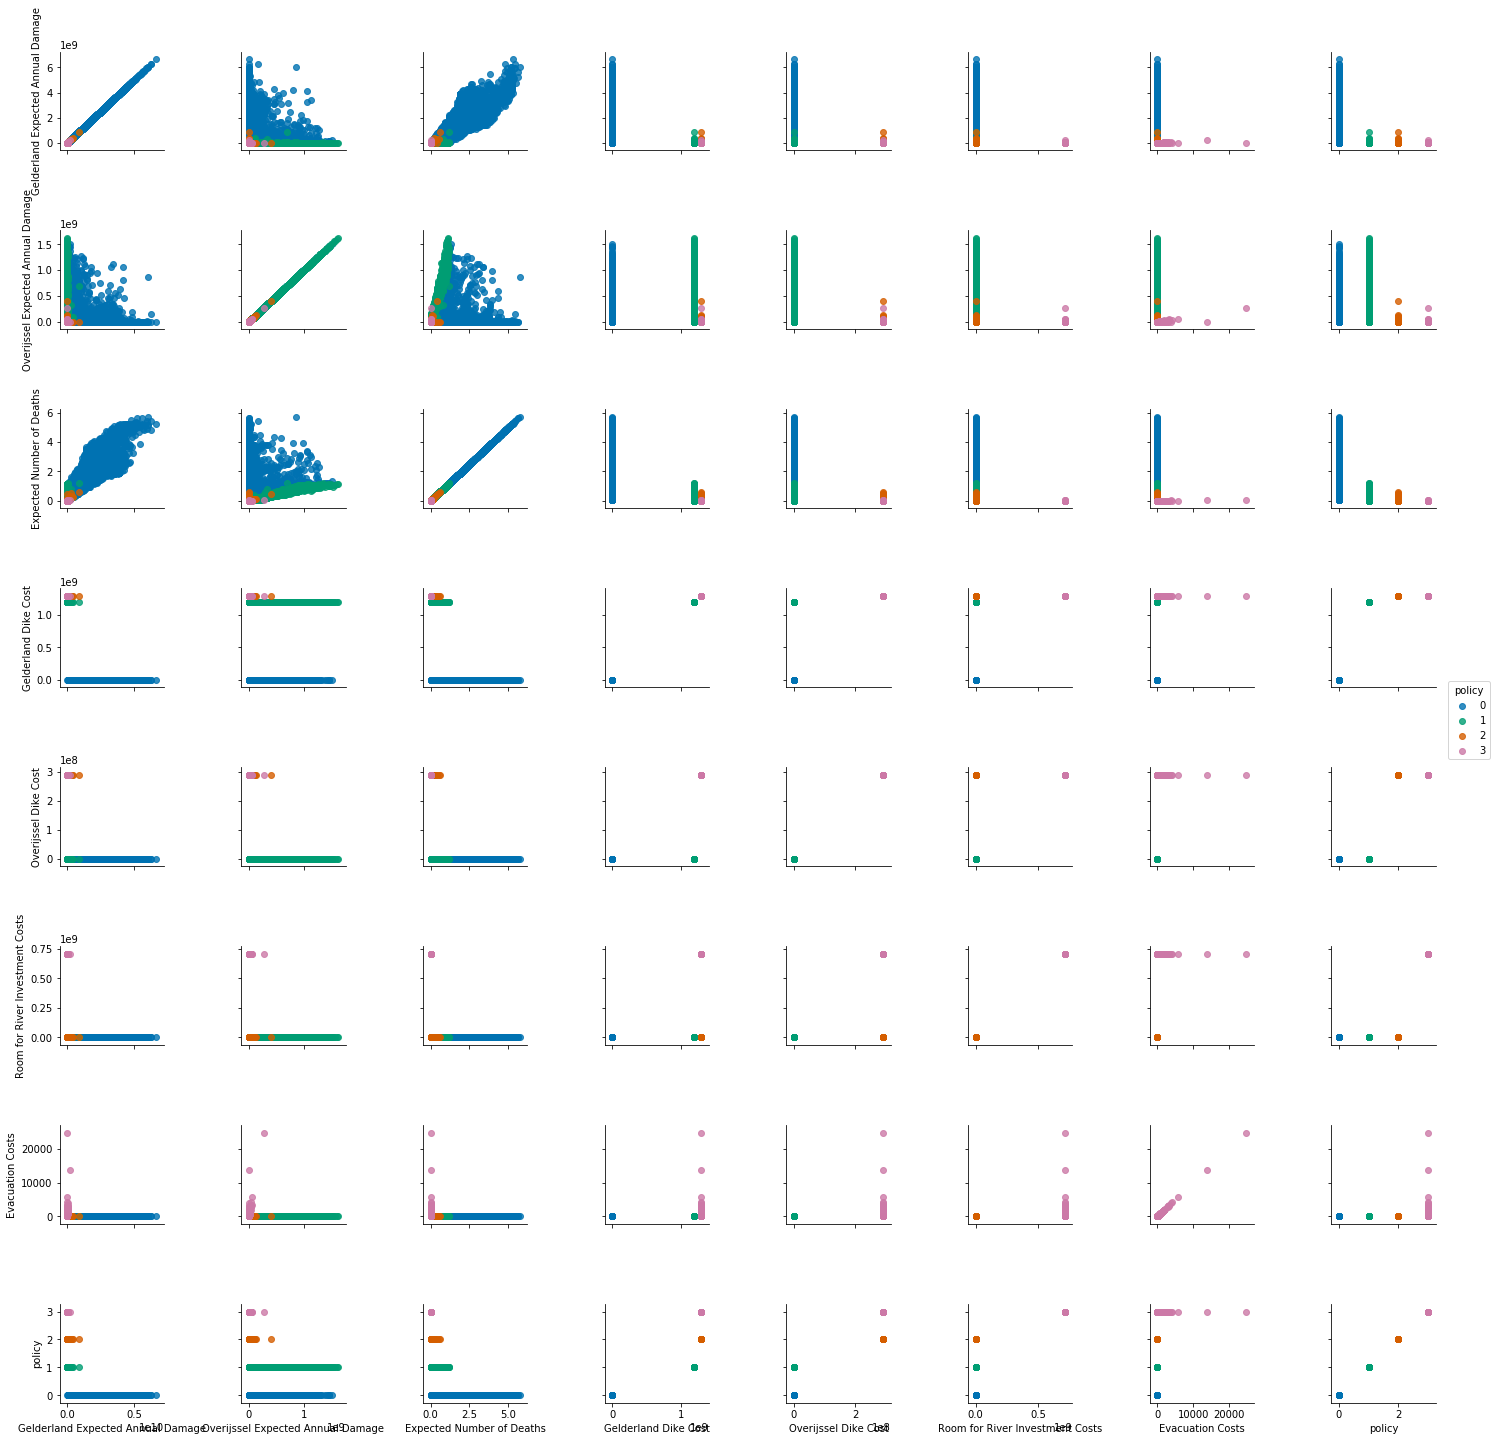

In [ ]:
g = sns.PairGrid(data, hue = 'policy', palette = 'colorblind')
g.map(plt.scatter, alpha = 0.8)
g.add_legend()

In [ ]:
data.loc[:5000,'policy'] = 'No Action'
data.loc[5000:10000,'policy'] = 'Gelderland Dikes'
data.loc[10000:15000,'policy'] = 'All dikes'
data.loc[15000:20000,'policy'] = 'Everything'

E:\Anaconda\lib\site-packages\seaborn\axisgrid.py:1241: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


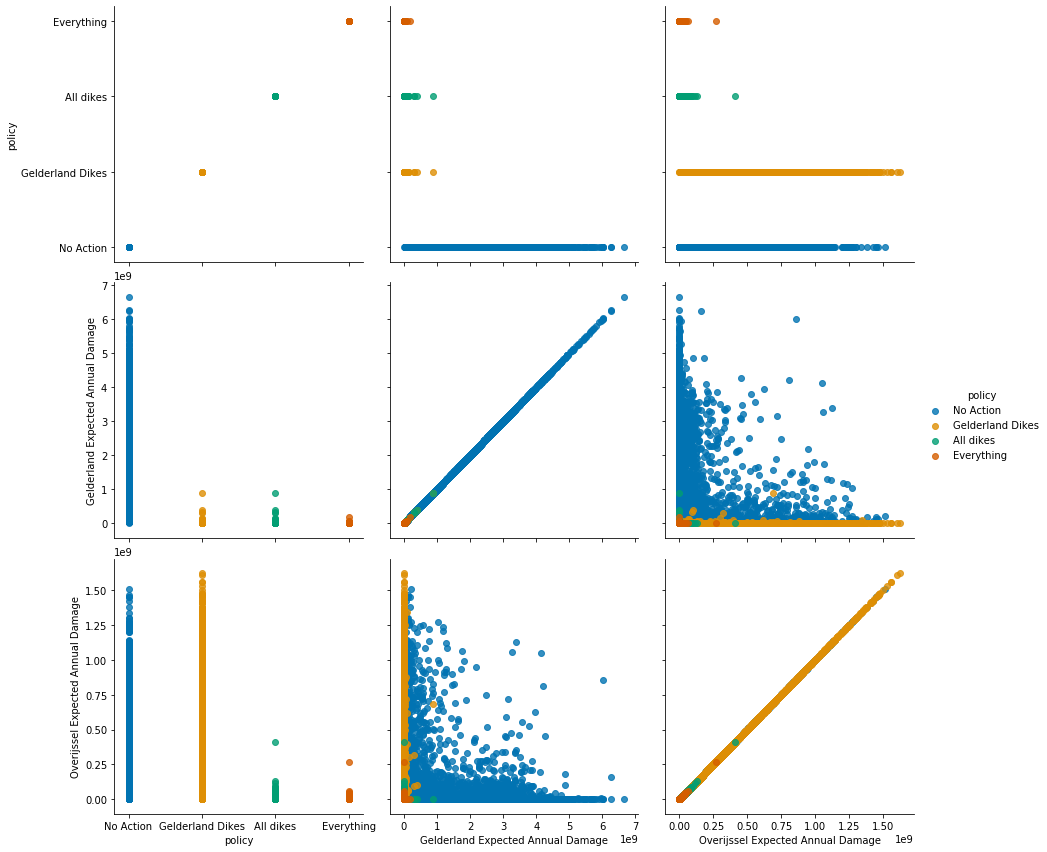

In [ ]:
g = sns.PairGrid(data, hue = 'policy', palette = 'colorblind', vars = ['policy','Gelderland Expected Annual Damage','Overijssel Expected Annual Damage'], size = 4)
g.map(plt.scatter, alpha = 0.8)
g.add_legend()

In [ ]:
#Tsplot

n_policies = 4
n_scenarios = len(experiments)/n_policies

policies = np.empty([len(experiments),1])
k = 0
l = n_scenarios
for i in range(len(experiments)):
    policies[i] = k
    if(i == l - 1):
        k = k+1
        l = l + n_scenarios
policies = policies.astype(int)

data = pd.DataFrame.from_dict(outcomes)
data['policy'] = policies

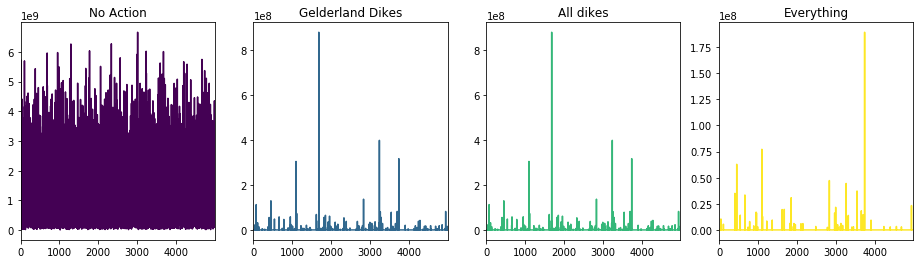

In [ ]:
from matplotlib.pyplot import cm


fig, axs = plt.subplots(figsize=[16,4],ncols = 4)
colors = iter(cm.viridis(np.linspace(0,1,4)))
l = ['No Action','Gelderland Dikes','All dikes','Everything']
for i in range(0,n_policies):
    sns.tsplot(data=data[data.policy == int(i)]['Gelderland Expected Annual Damage'].reset_index(drop=True),
              ax=axs[i],legend=True, color = next(colors)).set_title(l[i])

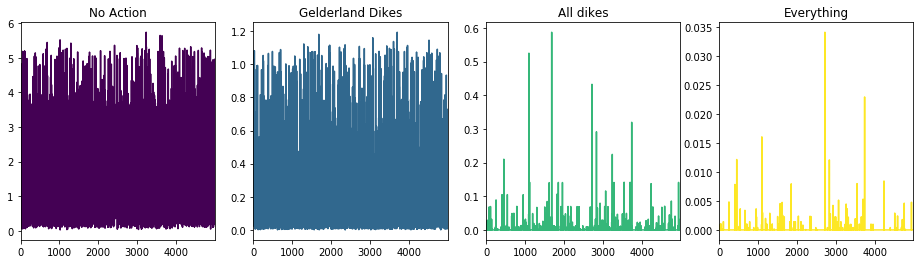

In [ ]:
from matplotlib.pyplot import cm


fig, axs = plt.subplots(figsize=[16,4],ncols = 4)
colors = iter(cm.viridis(np.linspace(0,1,4)))
l = ['No Action','Gelderland Dikes','All dikes','Everything']
for i in range(0,n_policies):
    sns.tsplot(data=data[data.policy == int(i)]['Expected Number of Deaths'].reset_index(drop=True),
              ax=axs[i],legend=True, color = next(colors)).set_title(l[i])